In [30]:
import pandas as pd
import numpy as np 
from pandas import ExcelWriter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Infos générales

### **Objectif du notebook**
Le notebook sert à calculer les émissions opérationnelles (e.g. Scope 1 et 2) des bâtiments résidentiels et tertiaires à partir du bilan énergétique (SDES), de facteurs d'émissions de la Base Carbone/Empreinte (ADEME), ainsi que des émissions de F-Gases du format SECTEN (CITEPA)

### **Zone géographique**

- **Métropole** (inclut la Corse)
- **France** (= Métropole + 5 DROM, Guadeloupe, Martinique, La Réunion, Mayotte)

### **Catégories d'énergie**

#### **Electricité**
Le bilan énergétique donne uniquement les consos totales, le découpage par usage se fait à travers les données RTE

#### **ENR thermique et déchets**
Cette catégorie est divisée en :
- Consommation d'énergie issue de déchets renouvelables dans le résidentiel
- Consommation d'énergie issue de déchets non renouvelables dans le résidentiel
- Consommation de biomasse solide dans le résidentiel
- Consommation de chaleur renouvelable issue des pompes à chaleur dans le résidentiel
- Consommation finale d'énergies renouvelables thermiques et déchets dans le résidentiel
- Consommation d'énergie solaire thermique dans le résidentiel

#### **Produits raffinés**
Cette catégorie, pour la zone **France**, est divisée en :
- GPL
- Fioul domestique

**Note :** La somme des GPL et fioul domestique n'est pas égale au total des produits raffinés.

# Import des données 

In [58]:
bilan_nrj = pd.read_excel(r'bilan_energetique_france_2021_series_longues.xlsx')
lca_ef = pd.read_excel('emission_factors.xlsx', sheet_name='life_cycle_emission_factors')
direct_ef = pd.read_excel('emission_factors.xlsx', sheet_name='direct_emission_factors')
rte_res = pd.read_excel('rte.xlsx', sheet_name='res_%_agg')
rte_nonres = pd.read_excel('rte.xlsx', sheet_name='nonres_%_agg')
f_gases = pd.read_excel(r'f_gases.xlsx')

# Données énergétiques

## Clean du bilan énergétique 

In [3]:
# Cleaning 
bilan_nrj.drop(columns=['CODTOT'], inplace=True)
bilan_nrj.drop(columns=[str(year) for year in range(1960, 2011)], errors='ignore', inplace=True)
bilan_nrj

,LIBSERIE,ENERGIE,UNITE,NIVGEO,TYPDONNEE,TYPFLUX,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Émissions de CO2 liées à la combustion de gaz ...,Gaz naturel,Mt CO2,France,CVC,Émissions de CO2,91.420656,87.757072,85.232506,81.855934,84.247151,87.557903,90.291881,88.127688,89.564487,87.611500,84.72256
1,Émissions de CO2 liées à la combustion de char...,Charbon,Mt CO2,France,CVC,Émissions de CO2,45.683552,48.245163,49.674574,39.795378,36.617784,34.595881,38.312262,35.461367,28.541002,21.200875,26.484931
2,Émissions de CO2 liées à la combustion de déch...,EnR et déchets,Mt CO2,France,CVC,Émissions de CO2,6.270829,6.474628,6.645731,6.827392,6.758252,7.039328,6.840091,6.873285,7.013666,6.584208,6.950596
3,Émissions de CO2 liées à la combustion de prod...,Pétrole,Mt CO2,France,CVC,Émissions de CO2,212.064537,201.900826,195.816448,196.372646,199.040875,191.355246,191.186965,185.502632,186.178100,160.491828,169.309462
4,Émissions de CO2 liées à la combustion d'énerg...,Toutes énergies,Mt CO2,France,CVC,Émissions de CO2,355.439574,344.377688,337.369259,324.851351,326.664062,320.548357,326.631199,315.964972,311.297255,275.888411,287.46755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,Transferts (brut et raffinés),Pétrole,TWh,France,Réelles,Branche énergie,65.367454,42.810241,18.070329,30.001680,17.040219,21.796066,18.168160,16.649371,29.186151,42.552605,26.931147
2099,Transferts (brut et raffinés),Pétrole,TWh,Métropole,Réelles,Branche énergie,65.033748,41.846992,17.727157,29.237234,16.085254,21.030437,17.245145,15.901173,28.642484,42.341968,26.931147
2100,Disponibilités (Consommation primaire) en prod...,Pétrole,TWh,DOM,Réelles,Consommation primaire,23.088971,21.549586,22.496777,24.810499,25.256137,25.205406,24.707677,24.319641,24.429418,23.507132,26.120386
2101,Disponibilités (Consommation primaire) en prod...,Pétrole,TWh,France,Réelles,Consommation primaire,881.725295,861.690075,846.339655,840.350820,848.411684,819.621672,827.074419,798.599983,795.428994,699.761453,745.840109


In [4]:
# To avoid duplicates
lines_to_remove = [
    "Consommation finale d'électricité dans le tertiaire (sans les non spécifiés)",
    "Consommation finale d'électricité dans secteur non spécifié", 
    "Consommation de GPL combustible par les ménages", 
    "Consommation de fioul domestique par les ménages"
]

bilan_nrj = bilan_nrj[~bilan_nrj['LIBSERIE'].isin(lines_to_remove)]

In [5]:
# Filtrage des données pour avoir uniquement les données en TWh pour le résidentiel et tertiaire pour la métropole
df_metro = bilan_nrj[(bilan_nrj['UNITE'] == 'TWh') &
                     (bilan_nrj['NIVGEO'] == 'Métropole') &
                     (bilan_nrj['TYPDONNEE'] == 'Réelles') &
                     (bilan_nrj['TYPFLUX'].isin(['Résidentiel', 'Tertiaire']))]

df_fr = bilan_nrj[(bilan_nrj['UNITE'] == 'TWh') &
                     (bilan_nrj['NIVGEO'] == 'France') &
                     (bilan_nrj['TYPDONNEE'] == 'Réelles') &
                     (bilan_nrj['TYPFLUX'].isin(['Résidentiel', 'Tertiaire']))]


In [6]:
df_metro.sort_values(by=['TYPFLUX', 'ENERGIE'], inplace=True)
df_fr.sort_values(by=['TYPFLUX', 'ENERGIE'], inplace=True)

C:\Users\pellan\AppData\Local\Temp\ipykernel_16672\858432996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metro.sort_values(by=['TYPFLUX', 'ENERGIE'], inplace=True)
C:\Users\pellan\AppData\Local\Temp\ipykernel_16672\858432996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fr.sort_values(by=['TYPFLUX', 'ENERGIE'], inplace=True)


## Ajout des consommations d'électricité par usage

In [7]:
# Identification des lignes à décomposer
consommation_residentiel = "Consommation finale d'électricité dans le résidentiel"
consommation_tertiaire = "Consommation finale d'électricité dans le tertiaire"

# Extraction des lignes concernées
ligne_residentiel = df_metro[df_metro['LIBSERIE'] == consommation_residentiel]
ligne_tertiaire = df_metro[df_metro['LIBSERIE'] == consommation_tertiaire]

In [8]:
def decomposer_consommation(ligne_base, df_pourcentages, typflux):
    nouvelles_lignes = []
    for _, row in df_pourcentages.iterrows():
        nouvelle_ligne = ligne_base.copy()
        nouvelle_ligne['LIBSERIE'] = f"Consommation d'électricité pour {row['TYPE']} dans le {typflux.lower()}"
        nouvelle_ligne['ENERGIE'] = 'Électricité'
        for year in range(2011, 2022):
            nouvelle_ligne[str(year)] = ligne_base[str(year)].values[0] * row[str(year)]
        nouvelles_lignes.append(nouvelle_ligne)
    return pd.concat(nouvelles_lignes, ignore_index=True)

In [9]:
def decompose_electricity_by_usage(metro_df, rte_res_agg_df, rte_nonres_agg_df, ligne_residentiel, ligne_tertiaire):
    # Décomposition des consommations d'électricité pour le résidentiel
    nouvelles_lignes_residentiel = decomposer_consommation(ligne_residentiel, rte_res_agg_df, 'Résidentiel')

    # Décomposition des consommations d'électricité pour le tertiaire
    nouvelles_lignes_tertiaire = decomposer_consommation(ligne_tertiaire, rte_nonres_agg_df, 'Tertiaire')

    # Suppression des lignes originales de consommation totale pour éviter la duplication
    metro_df_updated = metro_df[~metro_df['LIBSERIE'].isin([consommation_residentiel, consommation_tertiaire])]
    
    # Ajout des nouvelles lignes décomposées au dataframe
    metro_df_final = pd.concat([metro_df_updated, nouvelles_lignes_residentiel, nouvelles_lignes_tertiaire], ignore_index=True)
    
    # Tri par ordre alphabétique par 'TYPFLUX' et 'ENERGIE'
    metro_df_final_sorted = metro_df_final.sort_values(by=['TYPFLUX', 'ENERGIE'])

    metro_df_final_sorted = metro_df_final_sorted.reset_index(drop=True)
    
    return metro_df_final_sorted

In [10]:
# Application de la fonction pour obtenir le dataframe final décomposé et trié
df_metro = decompose_electricity_by_usage(df_metro, rte_res, rte_nonres, ligne_residentiel, ligne_tertiaire)
df_metro

,LIBSERIE,ENERGIE,UNITE,NIVGEO,TYPDONNEE,TYPFLUX,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Consommation finale de chaleur (vendue) dans l...,Chaleur vendue,TWh,Métropole,Réelles,Résidentiel,12.495856,13.690175,14.655318,11.984196,13.612457,14.680055,14.517453,14.706481,14.980747,14.491774,17.049854
1,Consommation finale de charbon dans le résiden...,Charbon,TWh,Métropole,Réelles,Résidentiel,0.470178,0.523815,0.550553,0.407678,0.421960,0.438102,0.412773,0.305708,0.283614,0.240750,0.303925
2,Consommation d'énergie issue de déchets renouv...,EnR et déchets,TWh,Métropole,Réelles,Résidentiel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,Consommation d'énergie issue de déchets non re...,EnR et déchets,TWh,Métropole,Réelles,Résidentiel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,Consommation de biomasse solide dans le réside...,EnR et déchets,TWh,Métropole,Réelles,Résidentiel,68.252390,79.146388,86.923470,70.379616,74.358876,79.475914,76.312826,73.814409,74.490218,68.536997,78.603249
5,Consommation de chaleur renouvelable issue des...,EnR et déchets,TWh,Métropole,Réelles,Résidentiel,10.387654,13.179960,15.572972,13.979604,16.559230,19.873081,21.249856,23.016939,26.665052,28.099863,37.229244
6,Consommation finale d'énergies renouvelables t...,EnR et déchets,TWh,Métropole,Réelles,Résidentiel,79.392177,93.162048,103.395696,85.313566,91.905601,100.356798,98.583666,97.863938,102.193836,97.681662,116.8859
7,Consommation d'énergie solaire thermique dans ...,EnR et déchets,TWh,Métropole,Réelles,Résidentiel,0.752132,0.835700,0.899255,0.954346,0.987496,1.007803,1.020984,1.032591,1.038566,1.044802,1.053406
8,Consommation finale de gaz naturel dans le rés...,Gaz naturel,TWh,Métropole,Réelles,Résidentiel,147.656731,163.467534,168.722310,126.079652,135.761992,146.891381,142.710068,134.307406,132.151217,125.059812,137.472958
9,Consommation finale de produits raffinés dans ...,Pétrole,TWh,Métropole,Réelles,Résidentiel,72.541114,76.626462,77.124816,63.854421,64.070357,60.059395,59.696906,53.856062,50.342131,48.231512,48.022721


In [11]:
#df_metro.to_excel(r'df_metro.xlsx', index=False)

# Calcul des émissions

## Calculs détaillés

In [13]:
def calculate_emissions(df_ef, df_nrj):
    # Copie des dataframes pour éviter les modifications en place
    df_ef_copy = df_ef.copy()
    df_nrj_copy = df_nrj.copy()

    for col in df_nrj.columns[6:]:  
        df_nrj_copy[col] = df_nrj_copy[col] * df_ef_copy[col] 
        
    # Mise à jour de l'unité
    df_nrj_copy['UNITE'] = 'MtCO2eq'
    
    return df_nrj_copy

In [14]:
# Utiliser la fonction pour calculer les émissions à partir des dataframes 'df_nrj_updated' et 'df_ef_updated'
df_emissions = calculate_emissions(df_metro, lca_ef)
df_emissions

## Calcul aggréges pour plot

In [55]:
def summarise_emissions(df):

    # Copier le dataframe pour éviter de modifier l'original
    df_copy = df.copy()
    
    # Définir les noms des lignes cibles pour l'agrégation
    target_residential = "Consommation finale d'énergies renouvelables thermiques et déchets dans le résidentiel"
    target_tertiary = "Consommation finale d'énergies renouvelables thermiques et déchets dans le tertiaire"
    
    # Agréger les valeurs pour 'EnR et déchets'
    for sector, target in zip(['Résidentiel', 'Tertiaire'], [target_residential, target_tertiary]):
        sum_values = df_copy[(df_copy['ENERGIE'] == 'EnR et déchets') & (df_copy['TYPFLUX'] == sector)].iloc[:, 6:].sum()
        target_index = df_copy[df_copy['LIBSERIE'] == target].index
        df_copy.loc[target_index, df_copy.columns[6:]] = sum_values.values
    
    # Supprimer les lignes 'EnR et déchets' qui ne sont pas les lignes cibles
    df_copy = df_copy.drop(df_copy[(df_copy['ENERGIE'] == 'EnR et déchets') & (~df_copy['LIBSERIE'].isin([target_residential, target_tertiary]))].index)
    
    # Lignes à supprimer selon les consommations spécifiées
    lines_to_drop = [
        "Consommation d'électricité pour chauffage dans le résidentiel",
        "Consommation d'électricité pour ecs dans le résidentiel",
        "Consommation d'électricité pour eclairage dans le résidentiel",
        "Consommation d'électricité pour climatisation dans le résidentiel",
        "Consommation d'électricité pour autres usages dans le résidentiel",
        "Consommation d'électricité pour chauffage dans le tertiaire",
        "Consommation d'électricité pour ecs dans le tertiaire",
        "Consommation d'électricité pour eclairage dans le tertiaire",
        "Consommation d'électricité pour climatisation dans le tertiaire",
        "Consommation d'électricité pour autres usages dans le tertiaire",
        "Consommation finale dans le résidentiel, toutes énergies confondues",
        "Consommation finale dans le tertiaire, toutes énergies confondues"
    ]
    
    # Supprimer les lignes spécifiées
    for line in lines_to_drop:
        df_copy = df_copy[~df_copy['LIBSERIE'].str.contains(line, case=False, na=False)]

    df_copy = df_copy.drop(columns=['LIBSERIE', 'UNITE', 'NIVGEO', 'TYPDONNEE'])
    df_copy.reset_index(drop=True, inplace=True)
    
    return df_copy

In [56]:
df_summary = summarise_emissions(df_emissions)
df_summary

,ENERGIE,TYPFLUX,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Chaleur vendue,Résidentiel,2.699105,2.738035,2.769855,2.205092,2.232443,2.246048,2.061478,2.103027,1.977459,1.869439,2.131232
1,Charbon,Résidentiel,0.177257,0.197478,0.207558,0.153695,0.159079,0.165164,0.155615,0.115252,0.106923,0.090763,0.11458
2,EnR et déchets,Résidentiel,2.007036,2.325379,2.552855,2.079422,2.195848,2.344335,2.253964,2.182647,2.202439,2.031330,2.321711
3,Gaz naturel,Résidentiel,33.518078,37.107130,38.299964,28.620081,30.817972,33.344343,32.395185,30.487781,29.998326,28.388577,31.206362
4,Pétrole,Résidentiel,23.575862,24.903600,25.065565,20.752687,20.822866,19.519303,19.401494,17.503220,16.361192,15.675242,15.607384
5,Électricité,Résidentiel,11.406654,12.362123,12.559788,10.679985,9.413324,9.170189,8.824416,8.979354,9.514499,9.487312,9.483633
6,Chaleur vendue,Tertiaire,1.589504,1.521543,1.525342,1.387567,1.337666,1.385034,1.332621,1.334062,1.228664,1.229762,1.367579
7,Charbon,Tertiaire,0.202284,0.225934,0.243187,0.181304,0.186061,0.192892,0.180195,0.158565,0.152432,0.133931,0.158988
8,EnR et déchets,Tertiaire,0.418066,0.435680,0.531805,0.451864,0.331643,0.376159,0.414123,0.363256,0.354423,0.397896,0.50173
9,Gaz naturel,Tertiaire,13.758088,15.726285,16.908335,14.524030,15.441576,15.705056,16.234231,15.995970,16.004623,14.213986,17.030677


In [62]:
# Ajout des F-Gases de CITEPA
df_operational = pd.concat([df_summary, f_gases], ignore_index=True)

In [63]:
df_operational

,ENERGIE,TYPFLUX,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Chaleur vendue,Résidentiel,2.699105,2.738035,2.769855,2.205092,2.232443,2.246048,2.061478,2.103027,1.977459,1.869439,2.131232
1,Charbon,Résidentiel,0.177257,0.197478,0.207558,0.153695,0.159079,0.165164,0.155615,0.115252,0.106923,0.090763,0.11458
2,EnR et déchets,Résidentiel,2.007036,2.325379,2.552855,2.079422,2.195848,2.344335,2.253964,2.182647,2.202439,2.031330,2.321711
3,Gaz naturel,Résidentiel,33.518078,37.107130,38.299964,28.620081,30.817972,33.344343,32.395185,30.487781,29.998326,28.388577,31.206362
4,Pétrole,Résidentiel,23.575862,24.903600,25.065565,20.752687,20.822866,19.519303,19.401494,17.503220,16.361192,15.675242,15.607384
5,Électricité,Résidentiel,11.406654,12.362123,12.559788,10.679985,9.413324,9.170189,8.824416,8.979354,9.514499,9.487312,9.483633
6,Chaleur vendue,Tertiaire,1.589504,1.521543,1.525342,1.387567,1.337666,1.385034,1.332621,1.334062,1.228664,1.229762,1.367579
7,Charbon,Tertiaire,0.202284,0.225934,0.243187,0.181304,0.186061,0.192892,0.180195,0.158565,0.152432,0.133931,0.158988
8,EnR et déchets,Tertiaire,0.418066,0.435680,0.531805,0.451864,0.331643,0.376159,0.414123,0.363256,0.354423,0.397896,0.50173
9,Gaz naturel,Tertiaire,13.758088,15.726285,16.908335,14.524030,15.441576,15.705056,16.234231,15.995970,16.004623,14.213986,17.030677


# Plots

In [68]:
def plot_ghge_data(data, title, figsize=(15, 8), title_size=20, axes_label_size=14, tick_size=18, legend_size=18):
    
    # Séparer les données en fonction de TYPFLUX
    residential_data = data[data["TYPFLUX"] == "Résidentiel"].set_index("ENERGIE").drop(columns="TYPFLUX")
    tertiary_data = data[data["TYPFLUX"] == "Tertiaire"].set_index("ENERGIE").drop(columns="TYPFLUX")

    # Définir une palette de couleurs distincte
    colors_palette = [
        '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#333333' 
    ]

    # Liste des énergies uniques
    energies = data["ENERGIE"].unique()

    # Créer le graphique
    fig, ax = plt.subplots(figsize=figsize)
    bar_width = 0.35
    index = range(len(residential_data.columns))

    # Barres pour Résidentiel
    bottom = [0] * len(residential_data.columns)
    for idx, energy in enumerate(energies):
        if energy in residential_data.index:
            ax.bar(index, residential_data.loc[energy], bar_width, label=f"{energy} (Residential)", color=colors_palette[idx], bottom=bottom, edgecolor='white')
            bottom += residential_data.loc[energy]

    # Barres pour Tertiaire avec hachures et un espacement augmenté
    bottom = [0] * len(tertiary_data.columns)
    for idx, energy in enumerate(energies):
        if energy in tertiary_data.index:
            ax.bar([i+bar_width + 0.05 for i in index], tertiary_data.loc[energy], bar_width, label=f"{energy} (Tertiary)", color=colors_palette[idx], alpha=0.6, bottom=bottom, edgecolor='white', hatch='//')
            bottom += tertiary_data.loc[energy]

    # Configurer les étiquettes et la légende avec les tailles spécifiées
    #ax.set_xlabel('Années', fontsize=axes_label_size)
    ax.set_ylabel('MtCO2eq', fontsize=18, fontweight='bold')
    ax.set_title(title, fontsize=title_size, fontweight='bold', pad=20)
    ax.set_xticks([i + bar_width + 0.025 for i in range(len(residential_data.columns))])  # Adjusted for the increased spacing
    ax.set_xticklabels(residential_data.columns, fontsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)

    # Légendes avec les tailles spécifiées
    energy_legends = [Patch(facecolor=colors_palette[idx], edgecolor='white', label=energy) for idx, energy in enumerate(energies)]
    custom_legends = [Patch(facecolor='white', edgecolor='black', label='Résidentiel'), 
                      Patch(facecolor='white', edgecolor='black', alpha=0.6, hatch='//', label='Tertiaire')]
    ax.legend(handles=custom_legends + energy_legends, loc="upper left", bbox_to_anchor=(1,1), prop={'size': legend_size})

    # Afficher le graphique
    plt.tight_layout()
    plt.show()

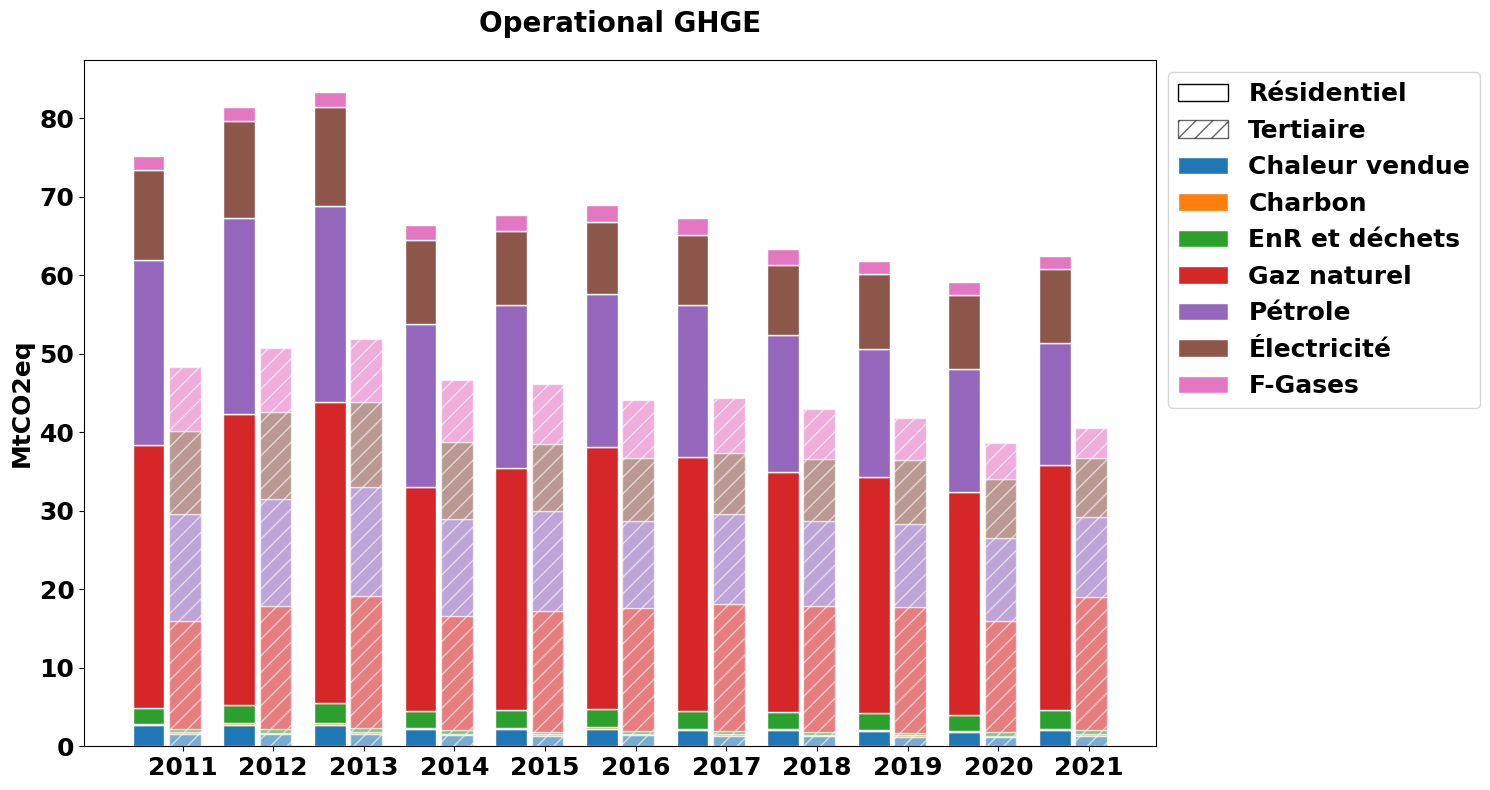

In [69]:
plot_ghge_data(df_operational, title='Operational GHGE')